<p style="text-align:center; font-size:32px; font-weight:bold; color:blue;">
    Multi-Classification NLP Model: Recipe Complaints
</p>

## Table of Contents

- Business Understanding
- Analytical Approach, Data Requirement/Collection/Understanding
- Data Preparation (Python or SQL)
- Dealing with Imbalanced Datasets
- Model Development
- Model Evaluation
- Model Deployment


## 1: Business Understanding

 Our goal is to find which machine learning model is best suited to predict sentiment (output) given a customer quality complaint (input).
 This will enable the quality department to quickly identify which customer related grouping is the most problematic and address formulation issues accordingly. It will also 
 help identify what keywords customers associate with different types of formulation issues and prevent manual classification which uses up valuable technician time.

## 2: Analytical Approach, Data Requirement,Data Collection and Data Understanding

2.1. Analytical Approach: Multi-Class Classification using SVM, Decision Tree, Naive Bayes and Logistic Regression using bag of words as the text representation technique since we are concerned with the words but not their order

2.2. Data Requirements : Require labelled dataset showing different quality reason codes associated with different customer complaint descriptions. The complaint descriptions will needs to be converted from text to numerical values before being used in the classification models. The reviews need to be formatted prior to conversion using the text representation technique

2.3. Data collection:
 > Data set is from the customer complaints department containing 3022 entries.
 > No sql required for database extraction.
 > The dataset contains 2 columns (customer complaint and complaint grouping) that will help us identify what customer description falls under which complaint grouping.


##### 2.4. Data Understanding (Exploratory Data Analysis/Descriptive statistics/data visualization)

In [28]:
# Read the dataset

import pandas as pd  
pd.set_option('display.max_columns', 2) 
df_Complaints= pd.read_excel('CustomerComplaints.xlsx') 
df_Complaints.head(10) 
print(df_Complaints) 




                                        Reason Reason group
0                                Lumpy product        Lumpy
1                                Lumpy product        Lumpy
2                     Incorrect product inside       Colour
3      Colour not matching Product Colour Card       Colour
4     Colour not matching product Colour guide       Colour
...                                        ...          ...
3016                             Viscosity Low    Viscosity
3017                          Washability poor        Bitty
3018                         Yellowing Product    Yellowing
3019                         Yellowing Product    Yellowing
3020                         Yellowing Product    Yellowing

[3021 rows x 2 columns]


> As can be seen the data consists of 3020 rows


In [29]:
# As can be seen data types for both columns are objects
df_Complaints.dtypes

Reason          object
Reason group    object
dtype: object

In [30]:
# Find the description of the dataset
pd.set_option('display.max_rows', None)
df_Complaints.describe()

# what does this tell you: 3021 reasons for customer complaints and 3019 reason groups. 99 unique reason codes and 109 unique reasons. Top issue is gelling.

,Reason,Reason group
count,3021,3019
unique,109,99
top,Gelled,Gelled
freq,468,365


In [31]:
# find a summary of the dataset
import pandas as pd
pd.set_option('display.max_rows', 40)
df_Complaints.shape

# 3021 rows, 2 columns in the dataframe

(3021, 2)

## 3: Data Preparation (Python or SQL)

#### 3.1. Data Imputation & Cleaning

In [32]:
# find all missing data
# counts null values and arranges columns in ascending order with the most missing values in % form

df_Complaints.isnull().sum().sort_values(ascending=False)   

# % of rows missing in each column
for column in df_Complaints.columns:   # loops through columns in dataframe
    percentage = df_Complaints[column].isnull().mean()   # find the percentage of each null value
    print(f'{column}: {round(percentage*100, 2)}%')   # rounds percentage to 2 decimal places
    
# For the given dataset there are missing Reason group values

Reason: 0.0%
Reason group: 0.07%


In [33]:
#Dealing with missing values will be done by removing the rows that have missing values since there are few entries

#dropna can automatically drop the null values in the row
df_Complaints = df_Complaints.dropna(subset=['Reason group'])   


In [34]:
df_Complaints.isnull().sum().sort_values(ascending=False)
# as can be seen new dataframe has no null values

Reason          0
Reason group    0
dtype: int64

In [35]:
pip install nltk

In [36]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pragesh.govender\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pragesh.govender\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pragesh.govender\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Pragesh.govender\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### 3.2. Normalization (tokenization, lowercasing, removing stop words) 

In [37]:
# [https://towardsdatascience.com/5-simple-ways-to-tokenize-text-in-python-92c6804edfc4]
# constant pre-processing on the whole data will not cause data spillage 
# can split data afterwards

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

# Make a copy of the DataFrame to avoid unintentional copy issues
df_normalized = df_Complaints.copy()

# Normalize 'Reason' column: Convert to lowercase and remove whitespace/punctuation
df_normalized['Reason'] = df_normalized['Reason'].apply(lambda x: x.lower().strip())
df_normalized['Reason'] = df_normalized['Reason'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Normalize 'Reason group' column: Convert to lowercase and remove whitespace/punctuation
df_normalized['Reason group'] = df_normalized['Reason group'].apply(lambda x: x.lower().strip())
df_normalized['Reason group'] = df_normalized['Reason group'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Tokenization: Tokenize 'Reason' column
# Word tokenization splits text data into individual words or tokens (base form)
df_normalized['tokenized_text'] = df_normalized['Reason'].apply(word_tokenize)

# Stopword Removal: Remove stopwords from 'tokenized_text' column
stop_words = set(stopwords.words('english'))
df_normalized['tokenized_text'] = df_normalized['tokenized_text'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

# Stemming or Lemmatization: Apply lemmatization to 'tokenized_text' column
# lemmatization is used because it is more accurate than stemming 
# considers context when converting text to its base form
lemmatizer = WordNetLemmatizer()
df_normalized['tokenized_text'] = df_normalized['tokenized_text'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

# Join tokens back into a single string so that it is compatible with TF_IDF
df_normalized['Reason_normalized'] = df_normalized['tokenized_text'].apply(lambda tokens: ' '.join(tokens))

# Display the updated DataFrame with normalized and tokenized text
print(df_normalized.head())

                                     Reason  ...  \
0                             lumpy product  ...   
1                             lumpy product  ...   
2                  incorrect product inside  ...   
3   colour not matching product colour card  ...   
4  colour not matching product colour guide  ...   

                      Reason_normalized  
0                         lumpy product  
1                         lumpy product  
2              incorrect product inside  
3   colour matching product colour card  
4  colour matching product colour guide  

[5 rows x 4 columns]


#### 3.3. Feature engineering (addition)

In [39]:
# need to turn customer complaint terms into numerical values for classifier/learning algorithm
# various text representation techniques such as one-hot-coding, bag of words, wor2vec, TF_IDF 
# TF_IDF will be used as the technique since we care about the frequency of words in the text review and order of words is relevant
# In our original dataset, we want to identify unique/representative words for each quality reason grouping, so we’ll choose the TF-IDF. To turn text data into numerical vectors with TF-IDF, we write the following code.


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer      

# splitting into train and test set needs to be done before TF-IDF 
# this prevents test and train data spilling and causing overfitting issues
# before using oversampling stratified sampling to have a real respresentation of the distribution
# once the split is done - do oversampling on the train set
# validation set can then be used to tune models use stratfied-Kfolds method
# test set can evaluate final model

# split dataset into train and test
# Can't use stratified sampling as some classes have less than one instances
#train, test = train_test_split(df_normalized, test_size=0.33,stratify=df_normalized['Reason group'], random_state=42)  

#random sampling
train, test = train_test_split(df_normalized, test_size=0.33, random_state=42) 

#Ensure that the tokenized column is used (pre-processing steps) before TF_IDF
train_x, train_y = train['Reason_normalized'], train['Reason group']   
test_x, test_y = test['Reason_normalized'], test['Reason group'] 

# Split the training set after oversampling into a validation and test set. Validation for tuning
# can't do stratified sampling because some classes have less than 2 instances
#X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2,stratify=train_y, random_state=42)    

#random sampling 
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)    

tfidf = TfidfVectorizer(stop_words='english')

train_x_vector = tfidf.fit_transform(X_train)
train_x_vector

#In the code above, we create a new instance of TfidfVectorizer(tfidf),
#we removed English stopwords and then fit (finds the internal parameters of a model) 
#and transform does the conversion to text


<1617x135 sparse matrix of type '<class 'numpy.float64'>'
	with 3429 stored elements in Compressed Sparse Row format>

In [41]:
#Matrix displayed visually
pd.DataFrame.sparse.from_spmatrix(train_x_vector,
                                  index=X_train.index,
                                  columns=tfidf.get_feature_names_out())

,adhering,...,yellowing
1277,0.0,...,0.0
2477,0.0,...,0.0
1482,0.0,...,0.0
222,0.0,...,0.0
1259,0.0,...,0.0
...,...,...,...
2815,0.0,...,0.0
137,0.0,...,0.0
746,0.0,...,0.0
2387,0.0,...,0.0


In [42]:
# Check the datatype of train_x_vector
print("Type of train_x_vector:", type(train_x_vector))

# Check if train_x_vector contains any non-numeric values
contains_strings = any(isinstance(val, str) for val in train_x_vector)
print("Contains strings in train_x_vector:", contains_strings)

# no non-numeric characters present

Type of train_x_vector: <class 'scipy.sparse.csr.csr_matrix'>
Contains strings in train_x_vector: False


In [43]:
# transform the test data set x so that can test the efficiency of the model later on

test_x_vector = tfidf.transform(test_x)
test_x_vector

<997x135 sparse matrix of type '<class 'numpy.float64'>'
	with 2111 stored elements in Compressed Sparse Row format>

In [44]:
# transform the validation dataset x so that it can tune the model later on

val_x_vector = tfidf.transform(X_val)
val_x_vector

<405x135 sparse matrix of type '<class 'numpy.float64'>'
	with 872 stored elements in Compressed Sparse Row format>

## 4: Dealing With Imbalanced Datasets

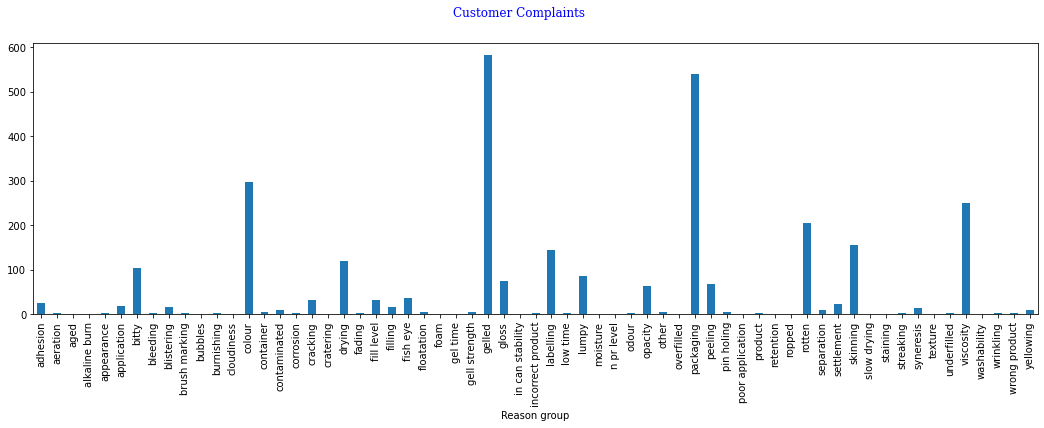

In [45]:
#No oversamling or undersampling is required

import matplotlib.pyplot as plt  # import pyplot to draw bar graph

f, ax = plt.subplots(figsize=(18,5))

font1 = {'family':'serif','color':'blue','size':10}      
font2 = {'family':'serif','color':'darkred','size':15}

plt.suptitle("Customer Complaints",fontdict = font1)     
df_gb = df_normalized.groupby(['Reason group']).size()

df_gb.plot.bar()
plt.show()   


# As can be seen the data is imbalanced, therefore multi-class balancing using SMOTE analysis could be carried out - however due to some classes having few entries SMOTE analysis is not possible

# random oversampling will be done - there is a risk of overfitting however some classes are very imbalanced. The other option is to just collect more data representative of the underperforming classes

In [47]:
from imblearn.over_sampling import RandomOverSampler

# Instantiate RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the TF-IDF vectors and corresponding labels using RandomOverSampler
train_x_resampled, train_y_resampled = oversampler.fit_resample(train_x_vector, y_train)



Original class distribution:
gelled              385
packaging           367
colour              194
viscosity           169
rotten              139
                   ... 
odour                 1
retention             1
moisture              1
poor application      1
slow drying           1
Name: Reason group, Length: 59, dtype: int64


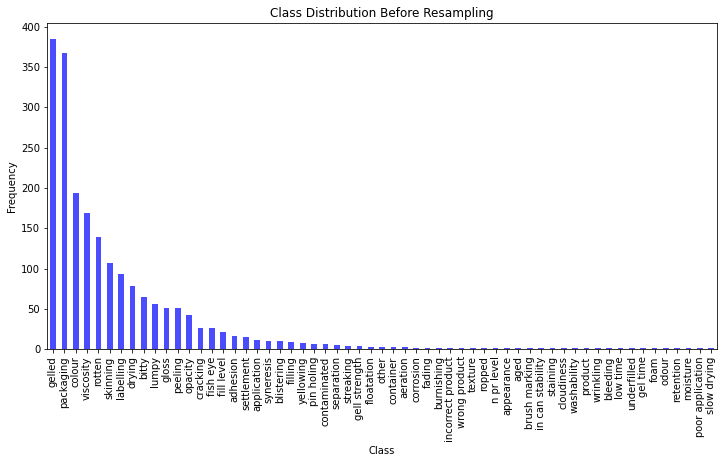

In [48]:
# Before resampling
original_class_distribution = train_y.value_counts()
print("Original class distribution:")
print(original_class_distribution)

# Plot original class distribution
plt.figure(figsize=(12, 6))
original_class_distribution.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Class Distribution Before Resampling')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

Resampled class distribution:
viscosity        325
gell strength    325
adhesion         325
wrong product    325
product          325
                ... 
staining         325
corrosion        325
blistering       325
application      325
texture          325
Name: Reason group, Length: 55, dtype: int64


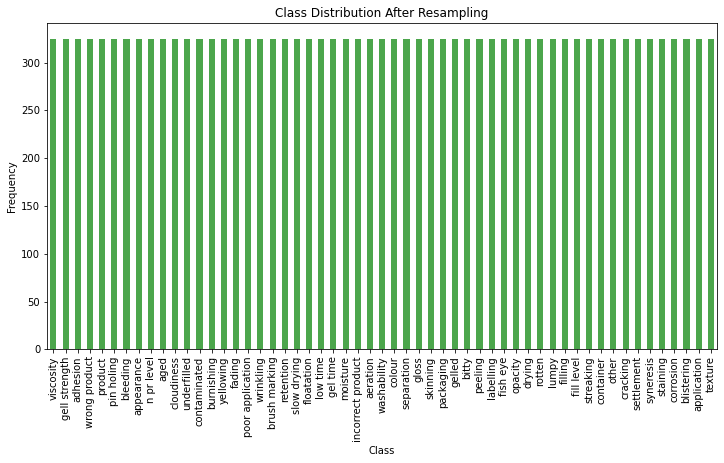

In [49]:
# After resampling
resampled_class_distribution = pd.Series(train_y_resampled).value_counts()
print("Resampled class distribution:")
print(resampled_class_distribution)

# Plot resampled class distribution
plt.figure(figsize=(12, 6))
resampled_class_distribution.plot(kind='bar', color='green', alpha=0.7)
plt.title('Class Distribution After Resampling')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# as can be seen the resampling worked

## 5: Model Development

#### 5.1. Split train into train and validation set

Already done in previous steps


#### 5.2. Model Training and Tuning

* with the numerical data, can experiment with different machine learning models and evaluate their accuracy
* Machine learning algorithms are divided between supervised learning and unsupervised learning. 
* In the first, models are trained using labeled data, while in the second 
* patterns are inferred from the unlabeled input data.
* In our example, our input (review) and output (reason group) are clearly identified, 
* so we can say we have labeled input and output data; 
* therefore, we’re dealing with supervised learning. 
* Two common types of supervised learning algorithms are Regression and Classification.
> Regression: They’re used to predict continuous values such as price, salary, age, etc
> Classification: They’re used to predict discrete values such as male/female, spam/not spam, positive/negative, etc.

* That said, it’s now evident that we should use classification algorithms. 
* We will benchmark the following four classification models (SVM, Decision Tree, Naive Bayes)
* This is used to maximize the model performance
* The grid search method will be used
* This is technique consists of an exhaustive search on specified parameters in order to obtain the optimum values of hyperparameters. 

* other examples of tuning: 

> * Bayesian Optimisation
> * Evolutionary Algorithms
> * Gradient-Based Optimisation. ...
> * Grid Search. ...
> * Keras' Tuner. ...
> * Population-based Optimisation. ...
> * ParamILS. ...
> * Random Search.

#### 4.2.1. Model 1: Support Vector Machines

In [54]:
# model tuning for svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# Define the parameters grid
# linear kernel (dot product of input features)
# The Radial Basis Function (RBF) kernel, which can handle non-linearly separable data by mapping it to a higher-dimensional space.
# C=1, regularization strength

parameters = {'C': 
              [1, 4, 8, 16, 32], 
              'kernel': ['linear', 'rbf']}

# Initialize SVC and GridSearchCV with parameters and cross-validation
svc = SVC()

# The k-fold cross validation method will be used
# Specify the number of splits (e.g., k=5)
# f1-weighted scoring - tuning will aim at improving the f1-score
Strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
svc_grid = GridSearchCV(svc, parameters, cv=Strat_kfold,scoring='f1_weighted')

# Fit GridSearchCV to filtered training data
svc_grid.fit(train_x_resampled, train_y_resampled)

# Evaluate the best estimator on the validation set (X_val, y_val) and see if need to tune parameters more before evaluation phase
# only measure that doesn't require you to calculate y_pred
Accuracy = svc_grid.best_estimator_.score(val_x_vector, y_val)  

# Predict labels on the validation set
y_pred_val = svc_grid.best_estimator_.predict(val_x_vector)
 

# for all models average score is calculated using the "weighted" method
# This ensures that the performance on minority classes is not overshadowed by the majority classes
Precision = precision_score(y_val, y_pred_val, average='weighted',zero_division=1) 
Recall = recall_score(y_val, y_pred_val, average='weighted',zero_division=1)
f1 = f1_score(y_val, y_pred_val, average='weighted',zero_division=1)


# Display best parameters and best estimator
print(svc_grid.best_params_)
print(svc_grid.best_estimator_)
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("f1:", f1)


{'C': 1, 'kernel': 'linear'}
SVC(C=1, kernel='linear')
Accuracy: 0.5358024691358024
Precision: 0.9072934839601506
Recall: 0.5358024691358024
f1: 0.6134683637360684


In [55]:
# lets do a test for overfitting and underfitting
# will do this by comparing the perfomance of the train set and the validation set and test set

Accuracy = svc_grid.best_estimator_.score(train_x_resampled, train_y_resampled)  
y_pred = svc_grid.best_estimator_.predict(train_x_resampled)
 

Precision = precision_score(train_y_resampled, y_pred, average='weighted',zero_division=1) 
Recall = recall_score(train_y_resampled, y_pred, average='weighted',zero_division=1)
f1 = f1_score(train_y_resampled, y_pred, average='weighted',zero_division=1)


# Display best parameters and best estimator
print(svc_grid.best_params_)
print(svc_grid.best_estimator_)
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("f1:", f1)

{'C': 1, 'kernel': 'linear'}
SVC(C=1, kernel='linear')
Accuracy: 0.8317762237762237
Precision: 0.8954909827540994
Recall: 0.8317762237762237
f1: 0.795894625537977


Based on the results, the train set performs more or less the same as the validation set, so can say that there is no overfitting 

Also with the train and validation set, model performance is relatively good, so no underfitting either


#### 4.2.2.Model 2: Decision Tree

In [56]:
#model tuning for decision tree

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the parameters grid for Decision Tree
parameters = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier()

# Initialize GridSearchCV with parameters and cross-validation (Leave-One-Out)
# Specify the number of splits (e.g., k=5)
Strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
dt_grid = GridSearchCV(dt, parameters, cv=Strat_kfold,scoring='f1_weighted')

#fit model with training data
dt_grid.fit(train_x_resampled,train_y_resampled)

# Evaluate the best estimator on the validation set (X_val, y_val) and see if need to tune parameters more before evaluation phase
Accuracy = dt_grid.best_estimator_.score(val_x_vector, y_val) 

# Predict labels on the test set
y_pred_val = dt_grid.best_estimator_.predict(val_x_vector)
 

Precision = precision_score(y_val, y_pred_val, average='weighted',zero_division=1) 
Recall = recall_score(y_val, y_pred_val, average='weighted',zero_division=1)
f1 = f1_score(y_val, y_pred_val, average='weighted',zero_division=1)


# Display best parameters and best estimator
print(dt_grid.best_params_)
print(dt_grid.best_estimator_)
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("f1:", f1)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier()
Accuracy: 0.5358024691358024
Precision: 0.9087184009406231
Recall: 0.5358024691358024
f1: 0.6131835505378997


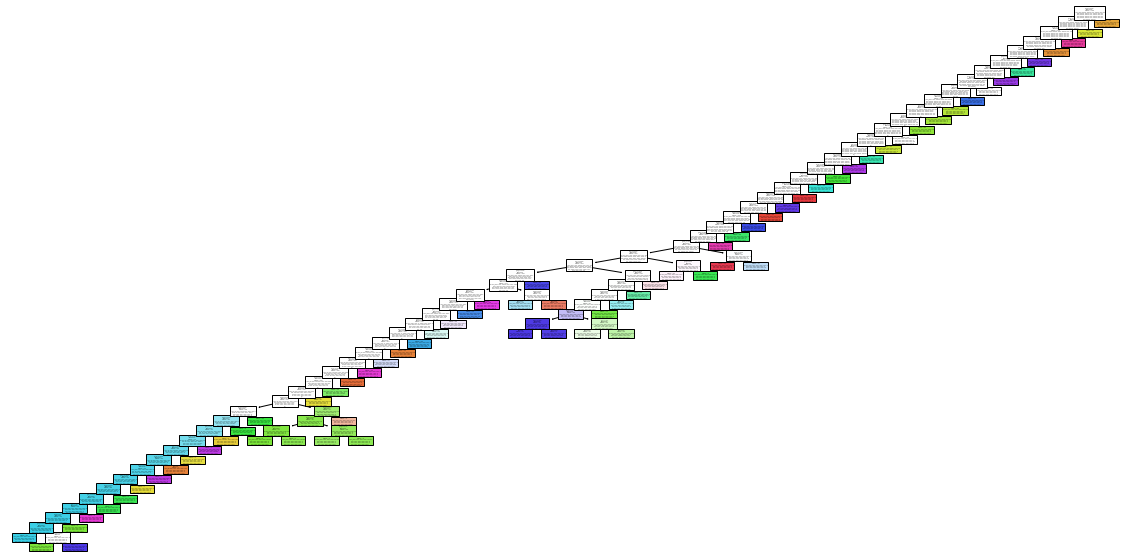

In [57]:
#visualize tree

from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(dt_grid.best_estimator_, filled=True)
plt.show()

In [58]:
# lets do a test for overfitting and underfitting
# will do this by comparing the perfomance of the train set and the validation set


Accuracy = dt_grid.best_estimator_.score(train_x_resampled, train_y_resampled)  
y_pred = dt_grid.best_estimator_.predict(train_x_resampled)
 

Precision = precision_score(train_y_resampled, y_pred, average='weighted',zero_division=1) 
Recall = recall_score(train_y_resampled, y_pred, average='weighted',zero_division=1)
f1 = f1_score(train_y_resampled, y_pred, average='weighted',zero_division=1)


# Display best parameters and best estimator
print(dt_grid.best_params_)
print(dt_grid.best_estimator_)
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("f1:", f1)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier()
Accuracy: 0.8317762237762237
Precision: 0.8954909827540994
Recall: 0.8317762237762237
f1: 0.795894625537977


Based on the results, the train set performs more or less the same as the validation set, so can say that there is no overfitting 

Also with the train and validation set, model performance is relatively good, so no underfitting either

#### 4.2.3. Model 3: Naive Bayes

In [59]:
# Model tuning for naive bayes

from sklearn.naive_bayes import GaussianNB 

# Define the parameters grid for Gaussian Naive Bayes
parameters = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Initialize Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Initialize GridSearchCV with parameters and cross-validation 
# Specify the number of splits (e.g., k=5)
Strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
gnb_grid = GridSearchCV(gnb, parameters, cv=Strat_kfold,scoring='f1_weighted')

# Fit GridSearchCV to filtered training data
# need to convert x to an array before model fitting
gnb_grid.fit(train_x_resampled.toarray(),train_y_resampled)

# Evaluate the best estimator on the validation set (X_val, y_val) and see if need to tune parameters more before evaluation phase
Accuracy = gnb_grid.best_estimator_.score(val_x_vector.toarray(), y_val)  

# Predict labels on the test set
y_pred_val = gnb_grid.best_estimator_.predict(val_x_vector.toarray())
 

Precision = precision_score(y_val, y_pred_val, average='weighted',zero_division=1) 
Recall = recall_score(y_val, y_pred_val, average='weighted',zero_division=1)
f1 = f1_score(y_val, y_pred_val, average='weighted',zero_division=1)


# Display best parameters and best estimator
print(gnb_grid.best_params_)
print(gnb_grid.best_estimator_)
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("f1:", f1)

{'var_smoothing': 1e-05}
GaussianNB(var_smoothing=1e-05)
Accuracy: 0.43950617283950616
Precision: 0.9136821477562217
Recall: 0.43950617283950616
f1: 0.48980824288320685


In [62]:
# lets do a test for overfitting and underfitting
# will do this by comparing the perfomance of the train set and the validation set


Accuracy = gnb_grid.best_estimator_.score(train_x_resampled.toarray(), train_y_resampled)  
y_pred = gnb_grid.best_estimator_.predict(train_x_resampled.toarray())
 

Precision = precision_score(train_y_resampled, y_pred, average='weighted',zero_division=1) 
Recall = recall_score(train_y_resampled, y_pred, average='weighted',zero_division=1)
f1 = f1_score(train_y_resampled, y_pred, average='weighted',zero_division=1)


# Display best parameters and best estimator
print(gnb_grid.best_params_)
print(gnb_grid.best_estimator_)
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("f1:", f1)

{'var_smoothing': 1e-05}
GaussianNB(var_smoothing=1e-05)
Accuracy: 0.8210909090909091
Precision: 0.8933190862735144
Recall: 0.8210909090909091
f1: 0.7784048162270465


Based on the results, the train set performs more or less the same as the validation set, so can say that there is no overfitting 

Also with the train and validation set, model performance is relatively good, so no underfitting either

#### 4.2.4. Model 4: Random Forest

In [72]:
# Random forests is an ensemble method (ensemble of decision trees)

from sklearn.ensemble import RandomForestClassifier
# Define the parameters grid for Random Forest
parameters = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [5, 10],       # Maximum depth of the trees
    'min_samples_split': [5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [4,6]    # Minimum number of samples required to be at a leaf node
}

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with parameters and cross-validation 
#stratified K-fold is used since we are dealing with an imbalanced validation set
Strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
rf_grid = GridSearchCV(rf, parameters, cv=Strat_kfold,scoring='f1_weighted')

# Fit GridSearchCV to filtered training data (X_val should be the training data, y_val should be the labels)
rf_grid.fit(train_x_resampled,train_y_resampled)

# Evaluate the best estimator on the validation set and see if need to tune parameters more before evaluation phase
Accuracy = rf_grid.best_estimator_.score(val_x_vector, y_val)  

# Predict labels on the test set
y_pred_val = rf_grid.best_estimator_.predict(val_x_vector)
 

Precision = precision_score(y_val, y_pred_val, average='weighted',zero_division=1) 
Recall = recall_score(y_val, y_pred_val, average='weighted',zero_division=1)
f1 = f1_score(y_val, y_pred_val, average='weighted')


# Display best parameters and best estimator
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("f1:", f1)

{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=42)
Accuracy: 0.5679012345679012
Precision: 0.9289359200470312
Recall: 0.5679012345679012
f1: 0.6214834225978283


In [73]:
# lets do a test for overfitting and underfitting
# will do this by comparing the perfomance of the train set and the validation set

Accuracy = rf_grid.best_estimator_.score(train_x_resampled, train_y_resampled)  
y_pred = rf_grid.best_estimator_.predict(train_x_resampled)
 
Precision = precision_score(train_y_resampled, y_pred, average='weighted',zero_division=1) 
Recall = recall_score(train_y_resampled, y_pred, average='weighted',zero_division=1)
f1 = f1_score(train_y_resampled, y_pred, average='weighted',zero_division=1)

# Display best parameters and best estimator
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("f1:", f1)

{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=42)
Accuracy: 0.7963636363636364
Precision: 0.8821338006575475
Recall: 0.7963636363636364
f1: 0.7537435578270011


Based on the results, the train set performs more or less the same as the validation set, so can say that there is no overfitting 

Also with the train and validation set, model performance is relatively good, so no underfitting either

# 5: Model Evaluation

In [ ]:
# the random forest seems to be the best performing and will be evaluated further

#### 5.1. Mean Accuracy and Other Measures

In [75]:
# .score method with the training set is used
# best model performance is the random forest 

print('rf_grid:', round(dt_grid.best_estimator_.score(test_x_vector, test_y),2))


rf_grid: 0.5


In [76]:
Accuracy = rf_grid.best_estimator_.score(test_x_vector, test_y)  
y_pred = rf_grid.best_estimator_.predict(test_x_vector)
 
Precision = precision_score(test_y, y_pred, average='weighted',zero_division=1) 
Recall = recall_score(test_y, y_pred, average='weighted',zero_division=1)
f1 = f1_score(test_y, y_pred, average='weighted',zero_division=1)

# Display best parameters and best estimator
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("f1:", f1)

{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=42)
Accuracy: 0.5506519558676028
Precision: 0.9358879223193165
Recall: 0.5506519558676028
f1: 0.5970038713417289


In [ ]:
# overall the model is displaying overfitting due to the under-represented classes
# lets look further at the individual classes to see this up close

#### 5.2. Classification Report

##### 5.2.1. Random Forest

In [90]:
from sklearn.metrics import classification_report

# Use the best estimator obtained from GridSearchCV
best_rf = rf_grid.best_estimator_

# Predict labels on the test set
predicted_labels = best_rf.predict(test_x_vector)

# Generate a classification report
report = classification_report(test_y, predicted_labels, output_dict=True,zero_division=1)

# Convert the report dictionary to a DataFrame
df_report = pd.DataFrame(report).transpose()

# Adjust pandas display settings to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Print the report in table form with averages
print("Classification Report:")
print(df_report)

Classification Report:
                   precision    recall  f1-score     support
adhesion            1.000000  0.900000  0.947368   10.000000
aeration            0.500000  1.000000  0.666667    1.000000
alkaline burn       1.000000  0.000000  0.000000    1.000000
appearance          1.000000  0.000000  0.000000    1.000000
application         1.000000  0.000000  0.000000    7.000000
bitty               0.456790  0.973684  0.621849   38.000000
bleeding            1.000000  0.000000  0.000000    3.000000
blistering          1.000000  1.000000  1.000000    7.000000
brush marking       1.000000  1.000000  1.000000    1.000000
bubbles             1.000000  0.000000  0.000000    1.000000
colour              0.976744  0.807692  0.884211  104.000000
container           0.000000  0.000000  0.000000    2.000000
contaminated        1.000000  0.000000  0.000000    3.000000
cracking            1.000000  1.000000  1.000000    5.000000
cratering           1.000000  0.000000  0.000000    1.000000
d

As can be seen, the model is good at predicting certain classes. Under-represented classes however are poorly represented. More data is required to improve the overall model accuracy.

#### 5.3. Confusion Matrix

##### 5.3.1. Random Forest

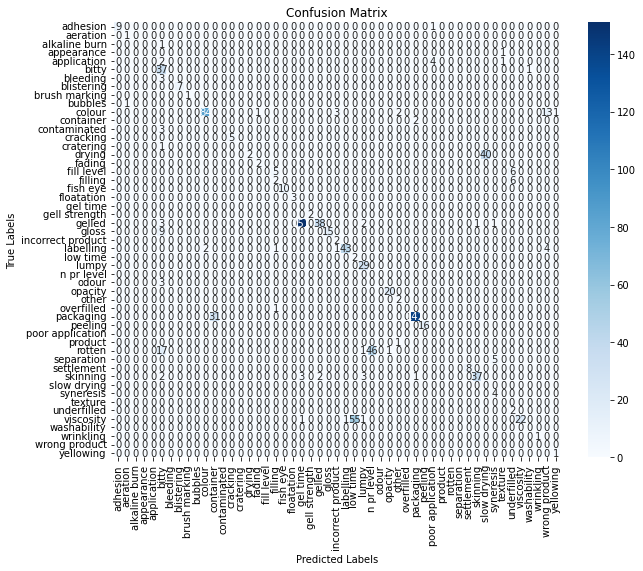

In [87]:
# Random Forest

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming svc_grid.best_estimator_ is the best SVM classifier obtained from GridSearchCV
best_rf= rf_grid.best_estimator_

# Predict labels on the test set
y_pred = best_rf.predict(test_x_vector.toarray())

# Get unique class labels from the predicted and true labels
classes = sorted(set(test_y) | set(y_pred))

# Compute confusion matrix
cm = confusion_matrix(test_y, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows the number of correctly predicted cases e.g. the issue of bittyness was correctly predicted 37 times. If you look at the analysis before oversampling - this class had one of the highest data points. This re-confirms that the model is good at predicting certain classes. There was one case of it being predicted incorrectly. Drying is an example of a class where the model performs poorly. All cases were incorrectly predicted. Before oversampling, this class had one of the lowest data points. 

Even with oversampling - the data is not reliable enough to assist the model. More data is required to improve the random forest model chosen.

# Step 6: Model Deployment 